In [1]:
# imports
import pandas as pd
import dsbhelper
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn import preprocessing
import random

/Users/farrar/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
%matplotlib inline

In [2]:
# constants
CLASSES = 'classes.csv'
TRAIN = './stage1_train'
TEST = './stage1_test'
TEST_GT = './stage1_test_gt'

In [3]:
# get the basic specimen metadata
df = pd.read_csv(CLASSES)
df.head(5)

filename foreground background
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black

In [4]:
# get training specimen list
train_specimen_ids = dsbhelper.get_specimen_ids(TRAIN)
for i in range(5):
    print (train_specimen_ids[i])

5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856
68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56
e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b
a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4


In [5]:
# get stage 1 test specimen list
test_specimen_ids = dsbhelper.get_specimen_ids(TEST)
for i in range(5):
    print (test_specimen_ids[i])

519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0
44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078
5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7
ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


In [6]:
# get stage 1 test ground truth specimen list
test_specimen_ids = dsbhelper.get_specimen_ids(TEST_GT)
for i in range(5):
    print (test_specimen_ids[i])

519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0
44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078
5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7
ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


In [7]:
# split out specimen id from filename
df['specimen_id']= df['filename'].str.split('.').str[0]
df.head(5)
#print(df['specimen_id'][0])

filename foreground background  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black   
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black   

                                         specimen_id  
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...  
1  4596961c789d3b41916492918797724fe75128239fefc5...  
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...  
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...  
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...

In [8]:
# --------------------------------
# add a column for train_or_test
# --------------------------------
def mark_train_or_test(df):

    train_or_test = []
    for row in df.specimen_id:

        if row in train_specimen_ids:
            train_or_test.append('train')

        elif row in test_specimen_ids:
            train_or_test.append('test')

        else:
            print('Error!')

    df['train_or_test'] = train_or_test
    
    return df

# unit test -------------------
df = mark_train_or_test(df)
df.head(5)

filename foreground background  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black   
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black   

                                         specimen_id train_or_test  
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...         train  
1  4596961c789d3b41916492918797724fe75128239fefc5...         train  
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...         train  
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...         train  
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...         train

In [9]:
# --------------------------------------
# adds nuclei count to the dataframe
# --------------------------------------
def add_nuclei_count(df):
    
    nuclei_count = []

    for row in df.specimen_id:
        if row in train_specimen_ids:
            nuclei_count.append(len(dsbhelper.get_specimen_mask_list(TRAIN, row)))

        elif row in test_specimen_ids:
            #nuclei_count.append(0)
            nuclei_count.append(len(dsbhelper.get_specimen_mask_list(TEST_GT, row)))
        
        else:
            print('Error!')

    df['nuclei_count'] = nuclei_count
    
    return df

# unit test -------------------
df = add_nuclei_count(df)
df.head(5)

filename foreground background  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black   
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black   

                                         specimen_id train_or_test  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...         train   
1  4596961c789d3b41916492918797724fe75128239fefc5...         train   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...         train   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...         train   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...         train   

   nuclei_count  
0            10  
1           133  
2            25  
3            20  
4            22

In [36]:
# --------------------------------------
# calculates how violet an image is
# ---------------------------------------
def get_violet_num(img):
    violet_num = 0
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if img[y, x][0] > img[y, x][1] and img[y, x][2] > img[y, x][1]:
                violet_num += 1

    return violet_num

# unit test -------------------
df_violets = df[df['foreground'] == 'purple']
df_violets.head(5)
violets = df_violets.values
#print (violets[0])
#print(violets[0,3])
img = dsbhelper.get_specimen_image(TRAIN, random.choice(violets[:,3]))
#img = dsbhelper.get_specimen_image(TRAIN, violets[0,3])
#print(get_violet_num(img))
plt.imshow(img)

['ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279.png'
 'purple' 'white'
 'ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279'
 'train' 42 26.0 888.0 391.2261904761905 256 320 185.35543212890624 55526]
ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279


In [11]:
# -----------------------------------------------------
# add descriptive statistics about masks
# -----------------------------------------------------
def add_mask_meta_data(df):
    
    # lists to store meta data
    areas = []
    area_mins = []
    area_maxes = []
    area_means = []    
    
    # loop and calcuate statistics
    for row in df.specimen_id:
        if row in train_specimen_ids:
            # get mask meta data
            masks = dsbhelper.get_specimen_masks(TRAIN, row)
            for mask in masks:
                rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
                gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
                _, contours, _ = cv2.findContours(gray.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for j, contour in enumerate(contours):
                    area = cv2.contourArea(contour)
                    areas.append(area)
                    #print('masks[{}] -> contour[{}] - > area={}'.format(i, j, area))

            # update lists
            areas = np.asarray(areas)
            area_mins.append(areas.min())
            area_maxes.append(areas.max())
            area_means.append(areas.mean())

            # reset for next loop
            areas = []

        # handle test data where the masks are not known
        else:
            area_mins.append(0)
            area_maxes.append(0)
            area_means.append(0)

    df['area_min'] = area_mins
    df['area_max'] = area_maxes
    df['area_mean'] = area_means
    
    return df

# unit test --------------------------------
df = add_mask_meta_data(df)
print(df.head(5))

                                            filename foreground background  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black   
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black   

                                         specimen_id train_or_test  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...         train   
1  4596961c789d3b41916492918797724fe75128239fefc5...         train   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...         train   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...         train   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...         train   

   nuclei_count  area_min  area_max    area_mean  
0            10      17.0     308.5   135.250000  
1       

In [12]:
def calc_population_stats(df):
    
    areas = []
    
    for row in df.specimen_id:
        if row in train_specimen_ids:
            masks = dsbhelper.get_specimen_masks(TRAIN, row)
            for mask in masks:
                rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
                gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
                _, contours, _ = cv2.findContours(gray.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                for j, contour in enumerate(contours):
                    area = cv2.contourArea(contour)
                    areas.append(area)
    
    areas = np.asarray(areas)
    
    return areas.min(), areas.max(), areas.mean()

# unit test ------------------------------------
pop_min, pop_max, pop_mean = calc_population_stats(df)
print('population min = {}'.format(pop_min))
print('population max = {}'.format(pop_max))
print('population mean = {}'.format(pop_mean))


population min = 0.0
population max = 10858.0
population mean = 425.3911634029949


In [13]:
# -----------------------------------------------------
# add descriptive statistics about images
# -----------------------------------------------------
def add_image_meta_data(df):

    img_mean_intensities = []
    img_violet_intensities = []
    img_heights= []
    img_widths = []
    
    for row in df.specimen_id:
        if row in train_specimen_ids:
            img = dsbhelper.get_specimen_image(TRAIN, row)
        elif row in test_specimen_ids:
            img = dsbhelper.get_specimen_image(TEST, row)
        else:
            print('Error!')

        img_mean_intensities.append(img.mean())
        img_violet_intensities.append(get_violet_num(img))
        img_heights.append(img.shape[0])
        img_widths.append(img.shape[1])

    df['image_height'] = img_heights
    df['image_width'] = img_widths
    df['image_mean_intensity'] = img_mean_intensities
    df['image_violet_intensity'] = img_violet_intensities
    
    return df

# unit test ------------------------------
df = add_image_meta_data(df)
print (df.head(5))


                                            filename foreground background  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...      white      black   
1  4596961c789d3b41916492918797724fe75128239fefc5...      white      black   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...      white      black   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...      white      black   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...      white      black   

                                         specimen_id train_or_test  \
0  d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...         train   
1  4596961c789d3b41916492918797724fe75128239fefc5...         train   
2  b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...         train   
3  831218e6a1a54b23d4be56c5799854e7eb978811b89215...         train   
4  b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...         train   

   nuclei_count  area_min  area_max    area_mean  image_height  image_width  \
0            10      17.0     3

In [14]:
def save_kfold_data(df, fname):
    df.to_csv(fname, index=False)

# unit test --------------------------
save_kfold_data(df, 'kfold_data.csv')

In [15]:
def resize_to_mean(path, specimen_id):

    areas = []
    pop_mean_nuclei_size = 425.391
    
    masks = dsbhelper.get_specimen_masks(path, specimen_id)
    for mask in masks:
        rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        _, contours, _ = cv2.findContours(gray.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            areas.append(area)
            
    areas = np.asarray(areas)
    specimen_mean_nuclei_size = areas.mean()
    
    resize_ratio = specimen_mean_nuclei_size / pop_mean_nuclei_size
    
    
    

    
    

In [16]:
def get_train_or_test_subset(df, subset='train'):
    return df.loc[df['train_or_test'] == subset]

# unit test -------------------------
print(df.shape)
df = get_train_or_test_subset(df)
print(df.shape)
print(df.area_mean.mean())

(735, 13)
(670, 13)
497.9097366137198


In [17]:
def make_feature_set(df):
    # columns to include
    feature_columns = ['foreground', 'background']
    
    return df[feature_columns].copy()

# unit test -------------------------
df_features = make_feature_set(df)
print (df_features.head(5))

  foreground background
0      white      black
1      white      black
2      white      black
3      white      black
4      white      black


In [18]:
def convert_text_features_to_int(features):
    
    for i, feature_list in enumerate(features):
        if feature_list[0] =='white':
            feature_list[0] = 1
        elif feature_list[0] == 'black':
            feature_list[0] = 2
        elif feature_list[0] == 'purple':
            feature_list[0] = 3

        if feature_list[1] =='white':
            feature_list[1] = 1
        elif feature_list[1] == 'black':
            feature_list[1] = 2
        elif feature_list[1] == 'purple':
            feature_list[1] = 3
        elif feature_list[1] == 'yellow':
            feature_list[1] = 4
        #print ('{} -> {}'.format(i,feature_list))

    return features

# unit test ----------------------------
features = df_features.values
features = convert_text_features_to_int(features)
print(features.shape)
print(features)


(670, 2)
[[1 2]
 [1 2]
 [1 2]
 ...
 [2 1]
 [2 1]
 [2 1]]


In [19]:
def generate_kfolds(clf, features, df):
    
    kfold_list = []    
    for i in range(features.shape[0]):
        kfold = kmeans.predict(features[i].reshape(1, -1))
        kfold_list.append([np.uint16(kfold[0]),         # class
                           df.iloc[i][1],               # fg color
                           df.iloc[i][2],               # bg color
                           df.iloc[i][3],               # specimen_id
                           np.float16(df.iloc[i][5]),   # nuclei_count
                           np.float16(df.iloc[i][6]),   # nuclei min
                           np.float16(df.iloc[i][7]),   # nuclei max
                           np.float16(df.iloc[i][8]),   # nuclei mean
                           np.uint16(df.iloc[i][9]),    # image_height
                           np.uint16(df.iloc[i][10]),   # image_width
                           np.float16(df.iloc[i][11]),  # mean_intensity
                           np.float16(df.iloc[i][12])]) # mean_violet
    
    return np.asarray(kfold_list)
    
# unit test -------------------------------
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features)
kfold_array = generate_kfolds(kmeans, features, df)
print(kfold_array.shape)

(670, 12)


In [20]:
def get_sets(kfold_array, n_clusters):
    
    clusters = []
    for i in range(n_clusters):
        clusters.append(kfold_array[np.uint8(kfold_array[:,0]) == i])
        
    return np.asarray(clusters)
# unit test --------------------------------
clusters = get_sets(kfold_array, n_clusters)
for i, cluster in enumerate(clusters):
    print('{}: {}'.format(i, cluster.shape))


0: (38, 12)
1: (546, 12)
2: (70, 12)
3: (16, 12)


In [21]:
def get_train_and_test_set(cluster, train_pct):
    
    test_set = []
    train_count = int(cluster.shape[0] * train_pct)
    test_count = cluster.shape[0] - train_count

    s = [sid for sid in cluster[:,3]]
    
    train_set = random.sample(s, train_count)
    
    for specimen_id in s:
        if specimen_id not in train_set:
            test_set.append(specimen_id)
    
    return train_set, test_set

# unit test ---------------------------------------------------
train_set, test_set = get_train_and_test_set(clusters[2], 0.8)
print(len(train_set))
print('Train Set -> {}'.format(train_set))
print(len(test_set))
print('Test Set -> {}'.format(test_set))


56
Train Set -> ['a90401357d50e1376354ae6e5f56a2e4dff3fdb5a4e8d50316673b2b8f1f293b', '3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940', 'f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300', '708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614', '8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca', '6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe', '136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261', '5ef4442e5b8b0b4cf824b61be4050dfd793d846e0a6800afa4425a2f66e91456', '4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20', '673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989', '2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7', '65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051', '8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b', '4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4', 'a7f6194ddbeaefb1da571226a97785

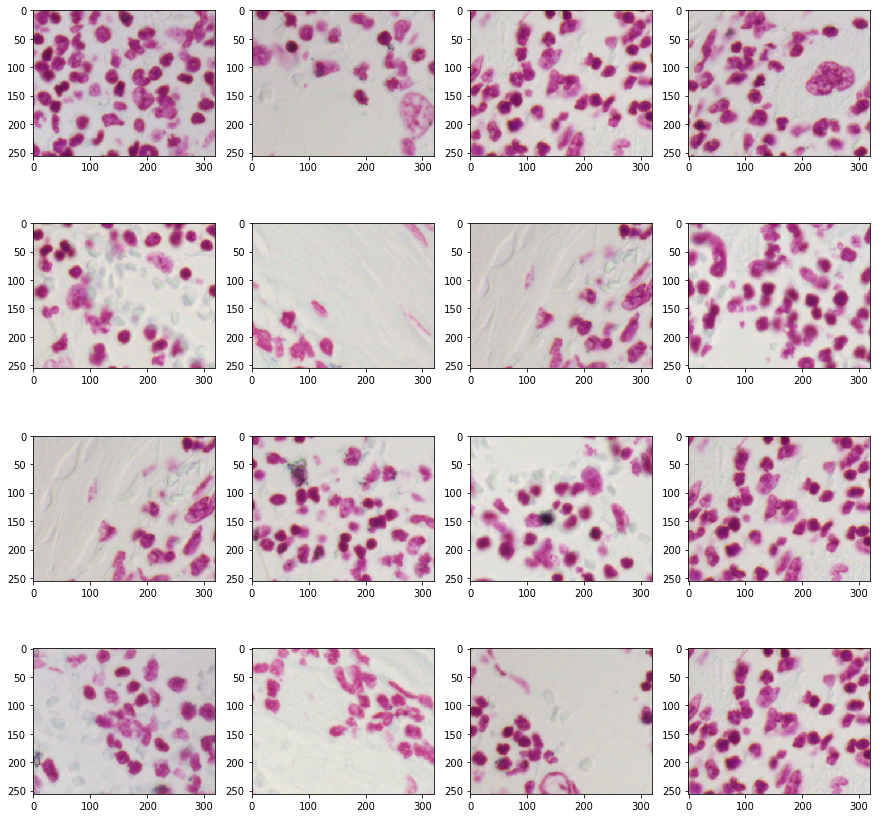

In [39]:
# Look at class 0 
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(clusters[0][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1
        

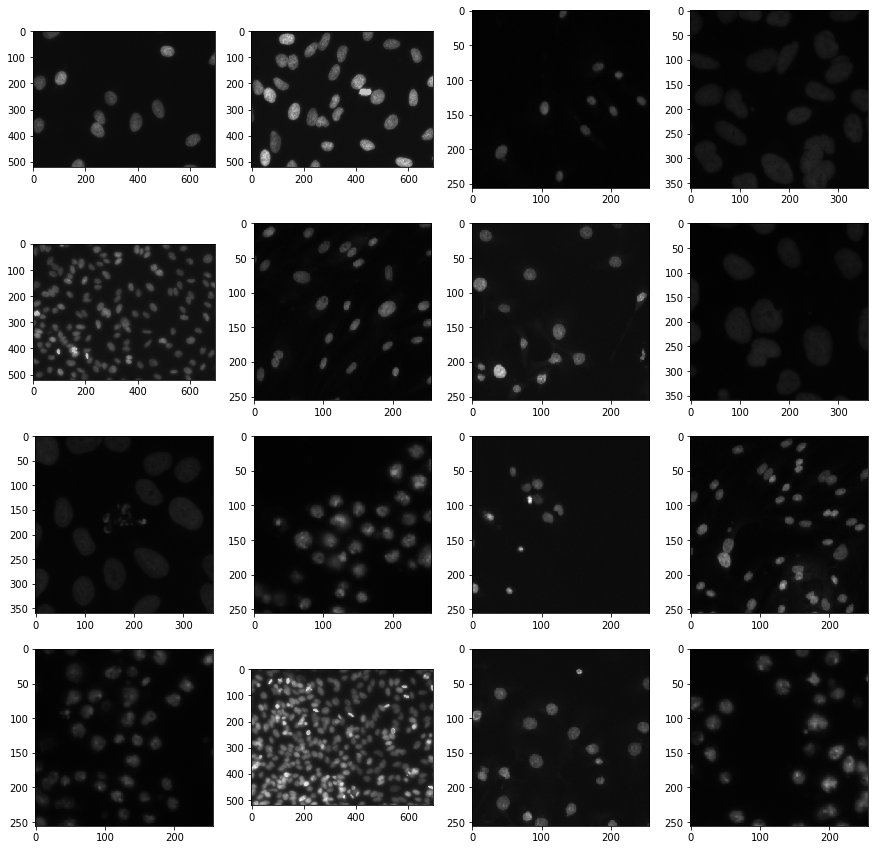

In [40]:
# Look at class 1
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(clusters[1][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

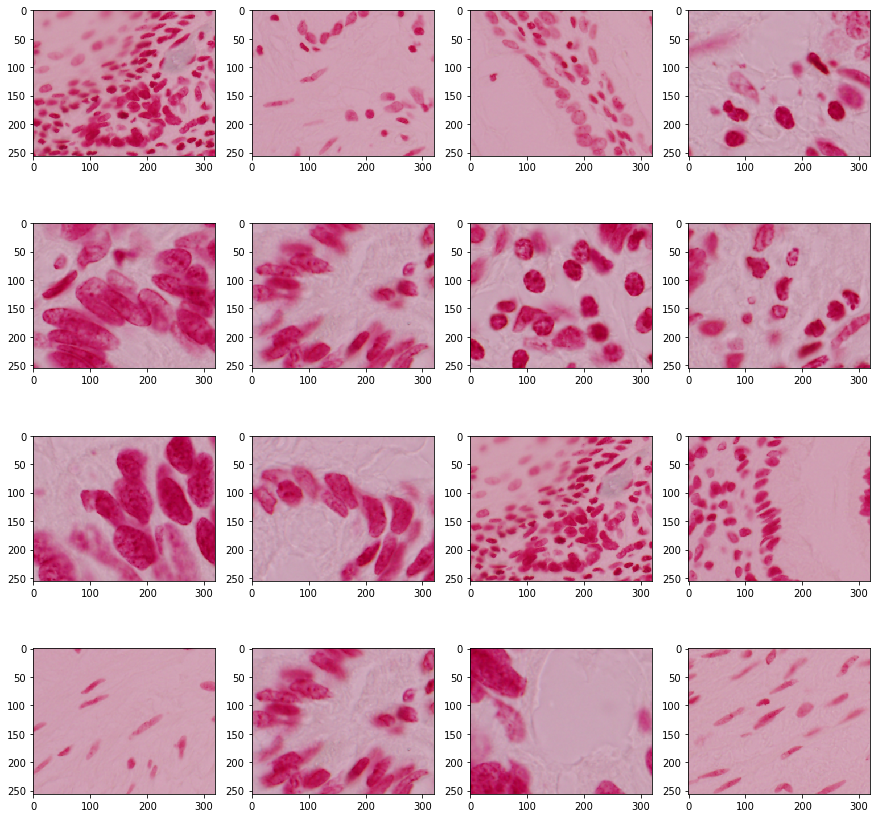

In [41]:
# Look at class 2
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(clusters[2][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

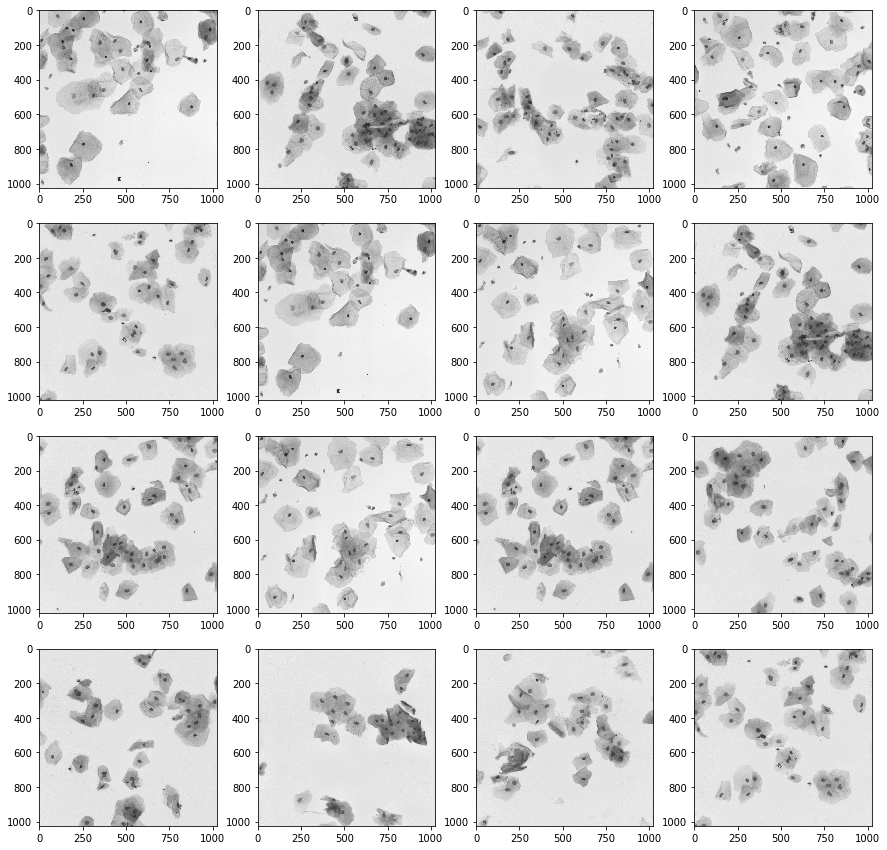

In [42]:
# Look at class 3
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(clusters[3][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

In [26]:
# ----------------------------------------------------------
# divide cluster into high and low intensity subclusters
# ----------------------------------------------------------
def subdivide_cluster_by_intensity(cluster, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters)
    features = cluster[:,[4,10]]
    kmeans.fit(features)
    
    sub_cluster = []
    for i, feature_set in enumerate(features):
        sub = kmeans.predict(feature_set.reshape(1, -1))
        sub_cluster.append([np.uint16(sub[0]),          # class
                           cluster[i][1],               # fg color
                           cluster[i][2],               # bg color
                           cluster[i][3],               # specimen_id
                           np.float16(cluster[i][4]),   # nuclei_count
                           np.float16(cluster[i][5]),   # nuclei min
                           np.float16(cluster[i][6]),   # nuclei max
                           np.float16(cluster[i][7]),   # nuclei mean
                           np.uint16(cluster[i][8]),    # image_height
                           np.uint16(cluster[i][9]),    # image_width
                           np.float16(cluster[i][10]),  # mean_intensity
                           np.float16(cluster[i][11])]) # mean_violet
        
    return np.asarray(sub_cluster)

    
    
    
# ----------------------
sub_kfolds = subdivide_cluster_by_intensity(clusters[0], 4)
sub_clusters = get_sets(sub_kfolds, 4)
for i, sub_cluster in enumerate(sub_clusters):
    print('{}: {}'.format(i, sub_cluster.shape))



0: (13, 12)
1: (5, 12)
2: (12, 12)
3: (8, 12)


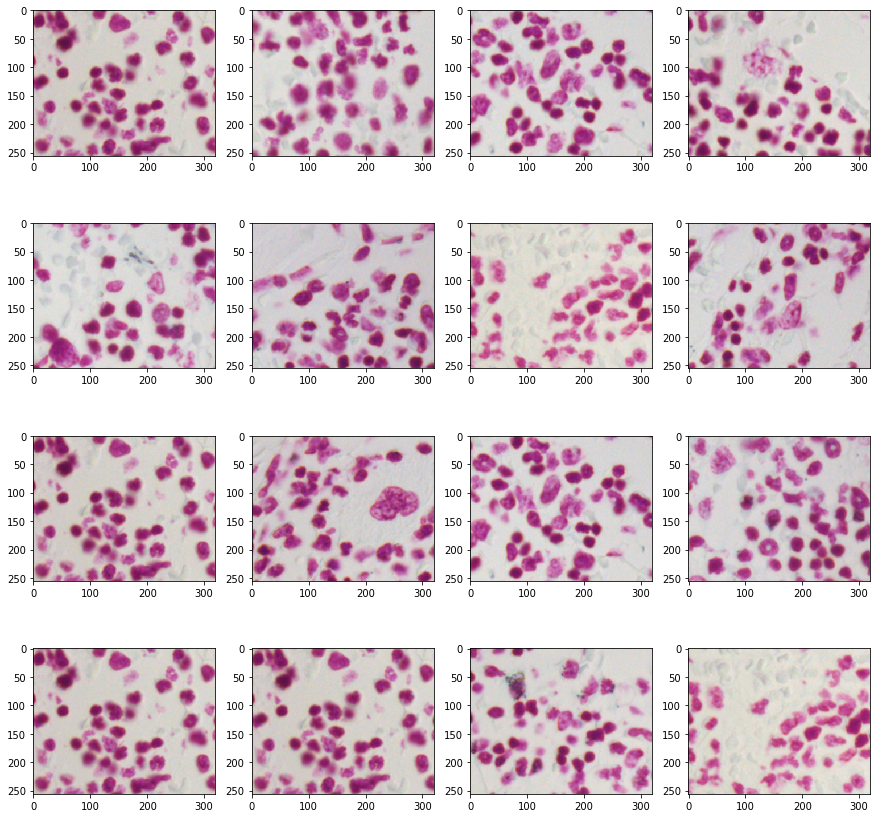

In [44]:
# Look at sub_class 0
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(sub_clusters[0][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]
nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

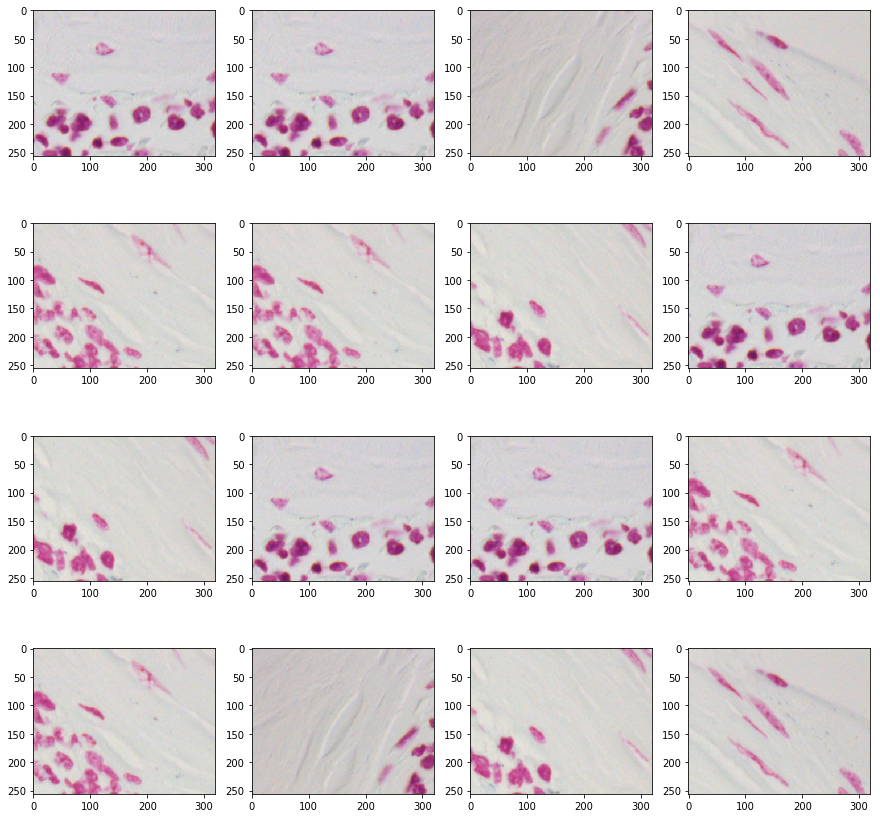

In [45]:
# Look at sub_class 1
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(sub_clusters[1][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

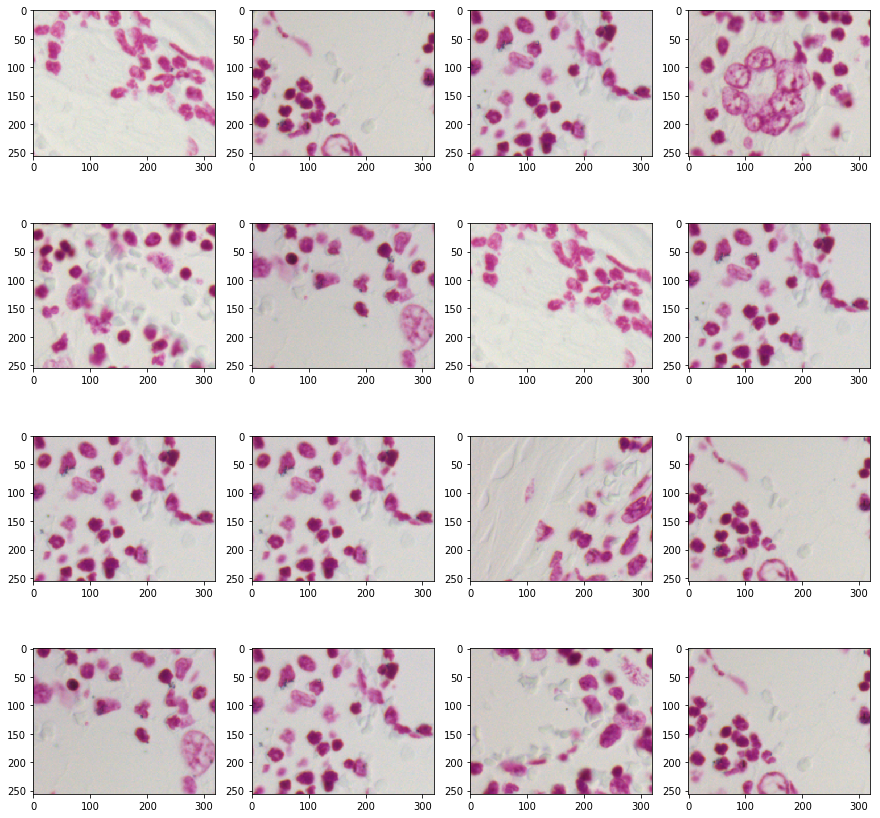

In [46]:
# Look at sub_class 2
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(sub_clusters[2][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

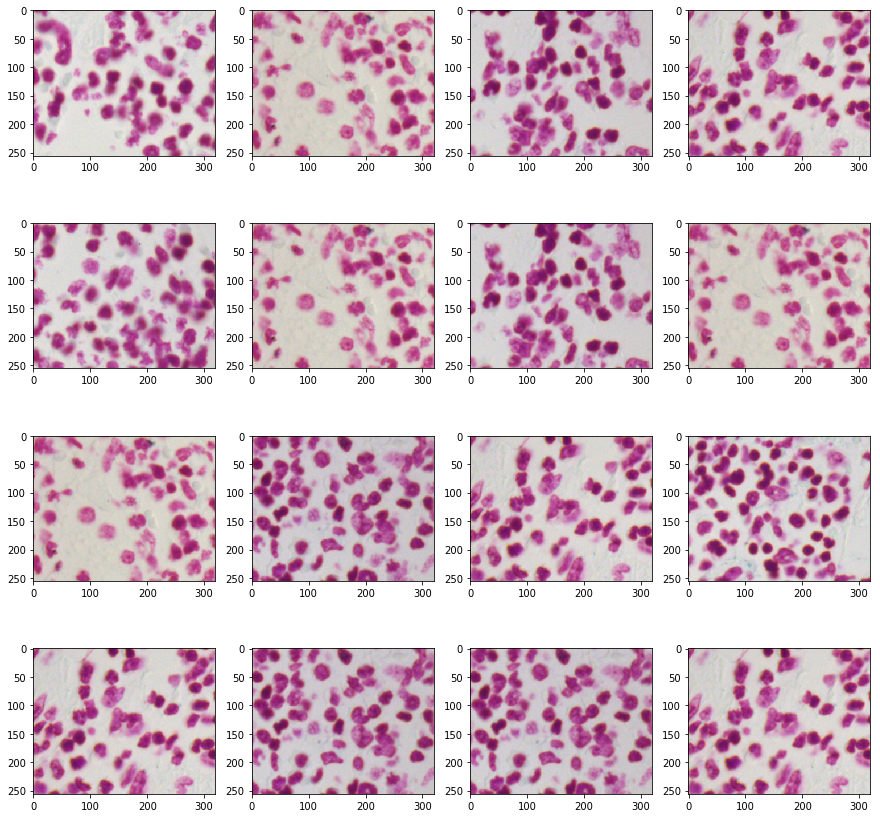

In [47]:
# Look at sub_class 2
specimen_ids = []
for i in range(16):
    specimen_id = (random.choice(sub_clusters[3][:,3]))
    specimen_ids.append(specimen_id)
images = [dsbhelper.get_specimen_image(TRAIN, s) for s in specimen_ids ]

nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))
i = 0
for row in range(nrows):
    for col in range(4):
        if i < len(images):
            axarr[row, col].imshow(images[i])
        i += 1

In [31]:
train_set, test_set = get_train_and_test_set(sub_clusters[3], 0.8)
print(len(train_set))
print('Train Set -> {}'.format(train_set))
print(len(test_set))
print('Test Set -> {}'.format(test_set))


6
Train Set -> ['5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51', '7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38', '79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96', 'ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548', '4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e']
2
Test Set -> ['0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed']


In [32]:
cluster_focus = ['4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40',  # black/white
                 '2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812',
                 '4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381',
                 '08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992',
                 'c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72',
                 '5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e',
                 '8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4',
                 '1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e',
                 '3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04',
                 '8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa',
                 '54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12',
                 '76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450',
                 '4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607', # purple/purple
                 'abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0',
                 '6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe',
                 'a90401357d50e1376354ae6e5f56a2e4dff3fdb5a4e8d50316673b2b8f1f293b',
                 '33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731',
                 '4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06',
                 '8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca',
                 'b0e35e06b85da49bfe3ea737711a72b551a6add446e30eabb01aa683a79873c5',
                 '4d4f254f3b8b4408d661df3735591554b2f6587ce1952928d619b48010d55467',
                 'bf4a61bb81589c9a67e3343408befd3e135af5e88b50c17f998f2131d24bc271',
                 '24a20f2a529cede5695df2422a3986505b5826bb10b10781d6db2074cf3de7b3',
                 '953211bcc0192e2298087d30e708dba68def9e0c13a3ff3326a18b0962c63adc',
                 '673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989',
                 '5ef4442e5b8b0b4cf824b61be4050dfd793d846e0a6800afa4425a2f66e91456',
                 '3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940',
                 'ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142',
                 '6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56',
                 'ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d',
                 '136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261',
                 'cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c',
                 '589f86dee5b480a88dd4f77eeaffe2c4d70aefdf879a4096dde1fa4d41055b8f',
                 '4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64',
                 'c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b',
                 'f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886',
                 'ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716',
                 '3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25',
                 '8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b',
                 '4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f',
                 '6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7e0b3f69de71d0d31c7',
                 'a7f767ca9770b160f234780e172aeb35a50830ba10dc49c526f4712451abe1d2',
                 'af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da',
                 'f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300',
                 'c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a',
                 '853a4c67900c411abd04467f7bc7813d3c58a5f565c8b0807e13c6e6dea21344',
                 '2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a',
                 'a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77',
                 '0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e',
                 '2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7',
                 '4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4',
                 '815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a',
                 '708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614',
                 '13f2bec0a24c70345372febb14c4352877b1b6c1b01896246048e83c345c0914',
                 '45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5',
                 'a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49',
                 '52a6b8ae4c8e0a8a07a31b8e3f401d8811bf1942969c198e51dfcbd98520aa60',
                 'be771d6831e3f8f1af4696bc08a582f163735db5baf9906e4729acc6a05e1187',
                 '3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20',
                 '6ab24e7e1f6c9fdd371c5edae1bbb20abeeb976811f8ab2375880b4483860f4d',
                 'b0e35e06b85da49bfe3ea737711a72b551a6add446e30eabb01aa683a79873c5',
                 'abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0',
                 '5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3',
                 '4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f',
                 'c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b',
                 '45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5',
                 'a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77',
                 'c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b',
                 'e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c', # purple/white
                 '94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0',
                 '353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606',
                 '420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f',
                 '947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050',
                 '7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38',
                 'af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0',
                 '610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96',
                 '4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e',
                 '2c61fdcb36fd1b2944895af6204279e9f6c164ba894198b40c8b7a3c9bf500ea',
                 'eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5',
                 '718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771',
                 'bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676',
                 'f4b7c24baf69b8752c49d0eb5db4b7b5e1524945d48e54925bff401d5658045d',
                 '1631352dbafb8a90f11219fffd3bea368a30bc3bad3bbe0e84e19bd720df4945',
                 '5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51',
                 'b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423',
                 'ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279',
                 'ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7',
                 'aa58ba4512955771b4f9b459cb4e6a8adb71d11cd6cae662ec2df31d688a5fe0',
                 '4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94',
                 'a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e',
                 '0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2',
                 'a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4',
                 '1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e',
                 '1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e',
                 '353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606',
                 'a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4',
                 '420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f',
                 '7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5',
                 'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288', # white/black sub 2
                 '8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842',
                 '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
                 '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
                 'c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932',
                 '547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6',
                 '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
                 '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
                 '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
                 '20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f',
                 '07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5',
                 'b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f', # white/black sub 3
                 'd4d6c683f249d82518431603bf0206d05f2114ac871a99ffade0f5f61cf167e1', 
                 '8d9b4205ddb10fa49a2973b4f3a2dc6923407ae015081e1a52c4b4c2fe8faa53', 
                 'c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1', 
                 'ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1', 
                 'a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606', 
                 'bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d', 
                 '4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2', 
                 '8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d', 
                 'c169a7782a69ea2f38f64d2739de189e88adbcfd4a829721def8c89ecabe8b71',
                 '8fdc34509a0c3721f7b5e235c8a93e1f553343aa17ad103a1e89e3509a3e1570'
]

In [33]:
validation_set =['7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121',  # purple/purple cluster
                 'cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd',
                 '2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074',
                 '0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6',
                 '442c4eb0185698fe7d148c108a46f74abd399aecda2f4f22981a1671cd95dd7d',
                 '709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7',
                 '87ea72894f6534b28e740cc34cf5c9eb75d0d8902687fce5fcc08a92e9f41386',
                 'a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d',
                 '65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051',
                 'b909aa8f6f4bec37c3fb6ff5a85d166162d07983506fcc57be742b0f9dbafbf7',
                 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
                 '1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f',
                 '4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20',
                 'ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548',  # purple/white cluster
                 '0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3',
                 '1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72',
                 '15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99',
                 '7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe',
                 '92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7',
                 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
                 '55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50',
                 '7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770', # black/white cluster
                 '1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df',
                 '091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d',
                 '5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d',
                 'ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce', # white/black sub 0
                 'fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c',
                 'df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2',
                 '9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32',
                 '2e172afb1f43b359f1f0208da9386aefe97c0c1afe202abfe6ec09cdca820990',
                 '930f246a8e4ff273a72a6e4b3cf8e8caff94fca4eaf1dbe6f93ba37b8195c0a0',
                 '3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875',
                 'cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a',
                 '0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe',
                 '3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd',
                 'e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203',
                 'c35e6e3ea39a718e1b7aff66e4cc678efd662f9b5336b74d69c1d6bca7aaf288',
                 'fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de',
                 'dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481',
                 '64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9',
                 '449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51',
                 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
                 '356d9903d16074f152fe8f2f0ef555d9959c53264228eae7373cad5cf35d4e85',
                 'e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0',
                 '4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149',
                 'da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920',
                 'f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24',
                 '4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e',
                 'da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8',
                 '12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e',
                 '4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0', # white/black sub 1
                 '2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d',
                 '98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0',
                 '538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e',
                 'da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844',
                 '4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9',
                 '150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f',
                 'a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710',
                 'c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d',
                 '9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a',
                 'b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac',
                 'cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490', # white/black sub 2
                 'd32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf', # white/black sub 3
                 '831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6',
                 'a22b7882fa85b9f0fcef659a7b82bfcddf01710f9a7617a9e036e84ac6901841',
                 '4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e',
                 'db45946a4412a2137674ec075b6892ccd682b77826aba618210569bbc65cf2b0',
                 'bb481eae02085bbae08742f702b9ab7d8b2ff9df2fbefeee9fac51f7c77dd01f',
                 'ead9464a50a17f74bf1b6471d94ecce8d887cf518c8fedc6c6048eb948bc4e49',
                 'd7fc0d0a7339211f2433829c6553b762e2b9ef82cfe218d58ecae6643fa8e9c7',
                 '619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483',
                 '1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d',
                 '4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06',
                 '6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72',
                 '9a71a416f98971aa14f63ef91242654cc9191a1414ce8bbd38066fe94559aa4f',
                 '6aa7dd0c88bec4f96cdd497f9c37779733033d9ec6513307461302d36bd32ac7',
                 '4b274461c6d001a7a9aeaf5952b40ac4934d1be96b9c176edfd628a8f77e6df2',
                 'e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b',
                 '514ccfc78cb55988a238d3ac9dc83460aa88382c95d56bcc0559962d9fe481ef',
                 '5419302571113e9aa74c7c0a9575333ca539b871a16c86ee92b35170b4ddc52e',
                 'a3a65623e079af7988b0c1cf1e54041003c6d730c91ecf200b71c47b93a67ed6',
                 'fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf',
                 '6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa',
                 '5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974',
                 '0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e',
                 'b1eb0123fe2d8c825694b193efb7b923d95effac9558ee4eaf3116374c2c94fe',
                 '08ae2741df2f5ac815c0f272a8c532b5167ee853be9b939b9b8b7fa93560868a',
                 'b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db',
                 '1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b',
                 '5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233',
                 '93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77',
                 '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9',
                 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
                 '1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e',
                 '45cc00f2ef95da6698bf590663e319d7c0ed4fb99d42dd3cf4060887da74fb81',
                 'b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4',
                 'd7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb',
                 'ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0',
                 '5488e8df5440ee5161fdfae3aeccd2ee396636430065c90e3f1f73870a975991',
                 'a815a986800a95de0957116c6585deea8ffb6ee09ad00ccc687306937ac698d0',
                 'ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48',
                 '6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f',
                 'f81ca7ee25e733ff37240c34c8e3044d9937bb0166e315952ebde3f237ecb86f',
                 '724b6b7044522f6d5ea35b55f8fa71d0a45a28687be2b7cac3149943ab816eec',
                 '305a8baaf726d7c9e695bff31d3a6a61445999a4732f0a3e6174dc9dcbe43931',
                 '30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789',
                 '91cc2e0d4d6e2c1ad59a8d63bcbe3e2ea8bc7f8e642e942a0113450181e73379',
                 'cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2',
                 'f113626a04125d97b27f21b45a0ce9a686d73dee7b5dbc0725d49194ba0203bd',
                 'd7d12a2acc47a94961aeb56fd56e8a0873016af75f5dd10915de9db8af8e4f5e',
                 'b7a86f4968071e0f963fa87ef314fdd1b6c73a66355431cc53a37e193ba6be9b',
                 'd4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5',
                 '14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf',
                 '44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01',
                 'fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5',
                 '7978812d0e2e034ee1f9c141f019705582fcaa290e4a01c6c75a62753285cb23',
                 'd910b2b1be8406caecfe31a503d412ffc4e3d488286242ebc7381836121dd4ef',
                 '0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c',
                 'a6515d73077866808ad4cb837ecdac33612527b8a1041e82135e40fce2bb9380',
                 '75120baa6abcbfe750a4eb223b8c10ae6bc3bebdda7b00d9a78bc2472fa28625',
                 '866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855',
                 '3a22fe593d9606d4f137461dd6802fd3918f9fbf36f4a65292be69670365e2ca',
                 '9c95eae11da041189e84cda20bdfb75716a6594684de4b6ce12a9aaadbb874c9',
                 'c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339',
                 'e66f25e175abab08ecb4e5f6859db64a211e0ddffb262d7e727b9d9bd4aad2d2',
                 'c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7',
                 '63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778',
                 'abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215',
                 'b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80',
                 'f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5',
                 'd1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0',
                 '7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e',
                 '0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275'
]

In [34]:

for specimen_id in cluster_focus:
    if specimen_id in validation_set:
        print (specimen_id)

In [35]:
z = 0
while z < 2:
    specimen_id = (random.choice(sub_clusters[3][:,3]))
    if specimen_id not in validation_set:
        print(specimen_id)
        z += 1

4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94
0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2
